<h1>Process Data</h1>
<h4>Haley Johnson</h4>

<p>Notebook to extract, combine and transform data</p>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 

In [189]:
sns.set_style("darkgrid")
sns.color_palette("husl", 9)
sns.set_context("paper")

<h2>Manipulate Happiness Data</h2>

In [2]:
html = pd.read_html("happiest_cities.html")

In [3]:
happiness_df = html[0]

In [4]:
happiness_df = happiness_df.rename(columns = {'City': 'Location'})

happiness_df['state'] = happiness_df['Location'].apply(lambda s: s.split(",")[-1])
happiness_df['city'] = happiness_df['Location'].apply(lambda s: s.split(",")[0])

happiness_df = happiness_df.drop(columns = ['Location'])

In [5]:
happiness_df['state'] = happiness_df['state'].str.strip().str.upper()
happiness_df['city'] = happiness_df['city'].str.strip().str.upper()

<h2>Manipulate Transportation Data</h2>

In [166]:
locations_df = pd.read_csv("EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv")

<h4>Remove Rows Where Location Is Missing</h4>

In [167]:
locations_df = locations_df[pd.isnull(locations_df['CBSA_Name']) == False]

In [168]:
for col in list(locations_df.columns):
    subset = locations_df[col]
    counts = pd.isnull(subset)
    counts = counts.value_counts()
    if True in counts.values:
        print(f"{col} contains missing values")

<h4>Setting Ranking Columns as Category</h4>

In [12]:
rankings = ['D2A_Ranked', 'D2B_Ranked', 'D3B_Ranked', 'D4A_Ranked']

for rank in rankings:
    locations_df[rank] = locations_df[rank].astype('category')

<h4>Get City and State Names</h4>

In [13]:
locations_df['CBSA_Name'] = locations_df['CBSA_Name'].astype(str)

In [14]:
locations_df['metro_area_cities'] = locations_df['CBSA_Name'].apply(lambda s: str(s).split(",")[0])
locations_df['metro_area_states'] = locations_df['CBSA_Name'].apply(lambda s: str(s).split(",")[-1])

locations_df['city'] = locations_df['metro_area_cities'].apply(lambda s: s.split("-"))
locations_df['state'] = locations_df['metro_area_states'].apply(lambda s: s.split("-"))

In [15]:
locations_df = locations_df.drop(columns = ['metro_area_cities', 'metro_area_states'])

<h3>Explode</h3>

In [16]:
exploded = locations_df.explode('city')
exploded = exploded.explode('state')
exploded = exploded.drop_duplicates()

In [17]:
exploded['city'] = exploded['city'].str.strip().str.upper()
exploded['state'] = exploded['state'].str.strip().str.upper()

<h2>Joining Happiness and Transportation Dataframes</h2>

<h4>Check that columns match</h4>

<p><b>St. Paul Minnestoa</b></p>

In [21]:
happiness_df[happiness_df['state'] == 'MN'][['city', 'state']]

,city,state
11,MINNEAPOLIS,MN
45,ST. PAUL,MN


In [22]:
exploded[exploded['state'] == 'MN'][['city', 'state']]

,city,state
125050,MINNEAPOLIS,MN
125050,ST. PAUL,MN
125050,BLOOMINGTON,MN
125051,MINNEAPOLIS,MN
125051,ST. PAUL,MN
...,...,...
217181,ST. PAUL,MN
217181,BLOOMINGTON,MN
217184,MINNEAPOLIS,MN
217184,ST. PAUL,MN


<p><b>New York City, NY</b></p>

In [23]:
happiness_df[happiness_df['state'] == 'NY'][['city', 'state']]

,city,state
43,YONKERS,NY
57,NEW YORK,NY
130,ROCHESTER,NY
135,BUFFALO,NY


In [24]:
exploded[exploded['state'] == 'NY'][['city', 'state']]

,city,state
141064,NEW YORK,NY
141064,NEWARK,NY
141064,JERSEY CITY,NY
141065,NEW YORK,NY
141065,NEWARK,NY
...,...,...
191967,NEWARK,NY
191967,JERSEY CITY,NY
191968,NEW YORK,NY
191968,NEWARK,NY


<p><b>Washington, D.C.</b></p>

In [25]:
happiness_df[happiness_df['state'] == 'DC'][['city', 'state']]

,city,state
84,WASHINGTON,DC


In [26]:
happiness_df[happiness_df['city'] == 'Arlington'][['city', 'state']]

,city,state


In [27]:
happiness_df[happiness_df['city'] == 'Alexandria'][['city', 'state']]

,city,state


In [28]:
exploded[exploded['state'] == 'DC'][['city', 'state']]

,city,state
15824,WASHINGTON,DC
15824,ARLINGTON,DC
15824,ALEXANDRIA,DC
15825,WASHINGTON,DC
15825,ARLINGTON,DC
...,...,...
212686,ARLINGTON,DC
212686,ALEXANDRIA,DC
212694,WASHINGTON,DC
212694,ARLINGTON,DC


<h4>Joining</h4>

In [29]:
matches = exploded.merge(happiness_df, on = ['state', 'city'])

In [63]:
# NOTE TO SELF: When you add new columns up above, you need to adjust these 
vals = list(matches.columns)[11:-8] + list(happiness_df.columns)[:-2]
df = pd.pivot_table(matches, index = ['city', "state"], values = vals, aggfunc = 'mean')

In [64]:
df = df.reset_index()

<h4>Add in Regions</h4>

<p>Based on <a href="https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf">census designations</a></p>

In [66]:
regions = {}

regions['Pacific'] = ['CA', 'OR', 'WA', 'HI', 'AK']

regions['Mountain West'] = ['ID', 'NV', 'MT','WY', 'UT', 'CO', 'AZ', 'NM']

regions['West North Central'] = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO']

regions['West South Central'] = ['TX', 'OK', 'AR', 'LA']

regions['East North Central'] = ['WI', 'IL', 'MI', 'IN', 'OH']

regions['East South Central'] = ['KY', 'TN', 'MS', 'AL']

regions['South Atlantiic'] = ['FL', 'GA', 'SC', 'NC', 'VA', 'WV', 'DC', 'MD', 'DE']

regions['Middle Atlantic'] = ['PA', 'NY', 'NJ']

regions['New England'] = ['ME', 'VT', 'NH', 'MA', 'CT', 'RI']

regions['US Territories'] = ['PR']

In [67]:
def get_region(s):
    keys = list(regions.keys())
    for key in keys:
        if s in regions[key]:
            return key
    return None

In [69]:
df['Region'] = df['state'].apply(get_region)

<h2>Data Visualization</h2>

<h3>Example of Why Aggregation Is Helpful</h3>

Text(0.5, 0.98, 'Effect of Aggregating by City on Analysis')

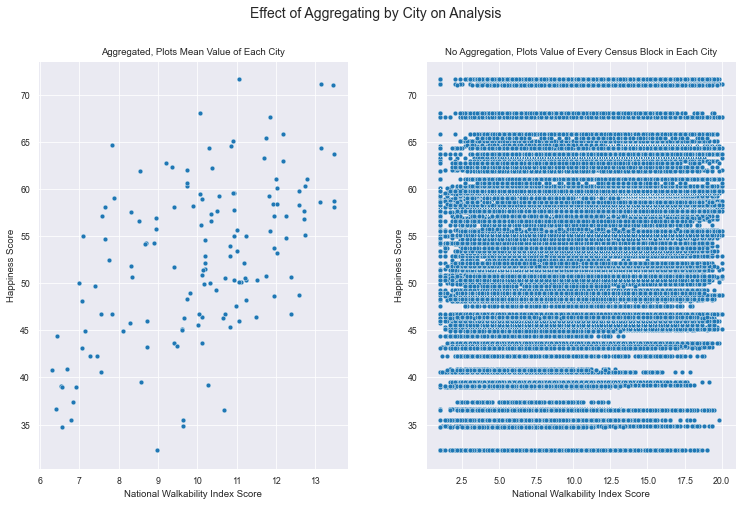

In [211]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12.5, 7.5)
fig.subplots_adjust(hspace=0.5, wspace = 0.25)

sns.scatterplot(x = 'NatWalkInd', y = 'Total Score', data = df, ax = axes[0])
sns.scatterplot(x = 'NatWalkInd', y = 'Total Score', data = matches, ax = axes[1])

# labels
axes[0].set_title('Aggregated, Plots Mean Value of Each City')
axes[0].set(ylabel = 'Happiness Score', xlabel = 'National Walkability Index Score')
axes[1].set_title('No Aggregation, Plots Value of Every Census Block in Each City')
axes[1].set(ylabel = 'Happiness Score', xlabel = 'National Walkability Index Score')

# annotations
# axes[0].annotate('figure pixels', xy=(160, 55), xycoords='figure pixels')

fig.suptitle("Effect of Aggregating by City on Analysis", fontsize = 14)

<h3>Actual Visualization</h3>

Text(0.5, 1.0, 'Scatterplot of Walkability vs Happiness Scores')

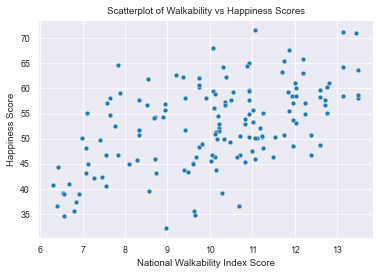

In [208]:
g = sns.scatterplot(x = 'NatWalkInd', y = 'Total Score', data = df)
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
g.set_title("Scatterplot of Walkability vs Happiness Scores")

Text(0.5, 1.0, 'Scatterplot of Walkability vs Happiness Scores')

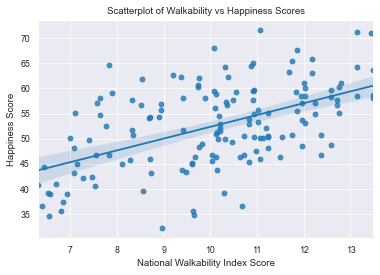

In [216]:
g = sns.regplot(x = 'NatWalkInd', y = 'Total Score', data = df)
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
g.set_title("Scatterplot of Walkability vs Happiness Scores")

Text(0.4, 1.05, 'Scatterplot of Walkability vs Happiness Scores')

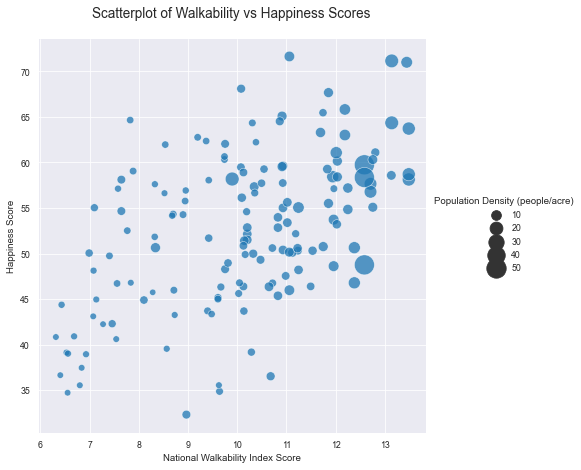

In [202]:
df = df.rename(columns = {'D1B' : 'Population Density (people/acre)'})

g = sns.relplot(x = "NatWalkInd", y = "Total Score", size = "Population Density (people/acre)",
            sizes = (40, 400), alpha = 0.75, palette = "muted", 
            height = 6, data = df)

# plt.legend(loc = 'lower right', borderaxespad = 2, title = 'Population Density (people/acre)')

g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
g.fig.suptitle("Scatterplot of Walkability vs Happiness Scores", y = 1.05, x = 0.4, fontsize = 13.5)


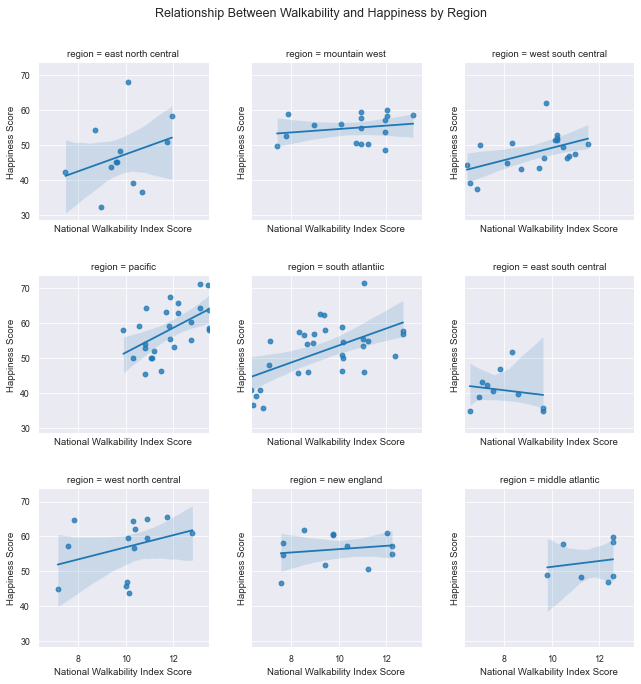

In [193]:
g = sns.FacetGrid(df, col="region", col_wrap = 3)
g.map(sns.regplot, "NatWalkInd", "Total Score")
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')

g.fig.suptitle("Relationship Between Walkability and Happiness by Region", y = 1.05, fontsize = 12.5)
g.fig.subplots_adjust(wspace = 0.25, hspace = 0.35)

In [223]:
by_region = matches.groupby('region')
happiness_by_region = by_region.describe()['Total Score'].sort_values(by = 'mean')

In [224]:
happiness_by_region

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
east south central,4971.0,41.676478,6.033524,34.71,35.54,40.60,43.10,51.83
east north central,19831.0,47.440022,10.395186,32.31,36.52,48.28,58.43,68.10
west south central,23510.0,50.686304,3.930263,37.45,49.31,51.50,52.14,62.04
south atlantiic,37136.0,54.280468,6.355812,35.53,50.64,55.05,57.61,71.64
middle atlantic,51158.0,54.699914,5.271524,46.78,48.75,58.35,59.74,59.74
west north central,11052.0,55.170367,8.548777,43.68,45.61,59.48,62.22,65.46
mountain west,17285.0,55.187654,4.026394,48.61,50.39,55.01,59.62,60.15
new england,9041.0,57.676315,3.714322,46.71,54.84,57.34,61.07,61.96
pacific,54241.0,59.985967,5.905415,45.36,58.13,58.70,63.72,71.15


In [226]:
by_region.describe()['NatWalkInd'].sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
east south central,4971.0,8.189901,4.003151,1.0,5.000000,7.500000,11.166667,19.833333
west south central,23510.0,9.973408,3.868395,1.0,6.833333,9.833333,13.000000,20.000000
west north central,11052.0,10.421915,4.042017,1.5,7.000000,10.666667,13.833333,19.833333
east north central,19831.0,10.432143,3.990279,1.0,7.000000,10.500000,13.666667,20.000000
south atlantiic,37136.0,10.720599,4.145837,1.0,7.000000,11.333333,14.000000,20.000000
new england,9041.0,11.197434,4.316616,1.0,7.166667,12.000000,14.833333,20.000000
mountain west,17285.0,11.317819,3.810587,1.0,8.166667,12.000000,14.333333,20.000000
middle atlantic,51158.0,12.416347,3.734831,1.0,9.833333,13.166667,15.166667,20.000000
pacific,54241.0,12.665640,3.699553,1.0,10.666667,13.333333,15.333333,20.000000


Text(0.5, 0.98, 'Walkability Index vs Happiness Score Components')

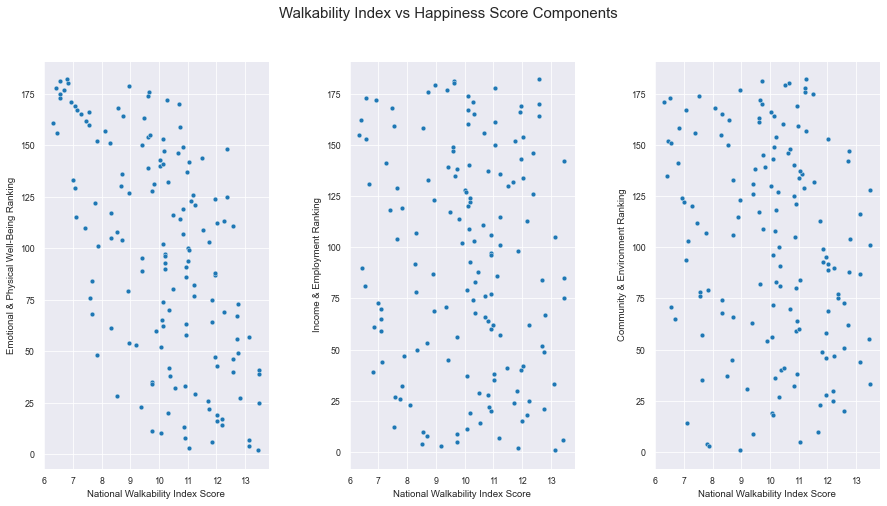

In [206]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(15, 7.5)
fig.subplots_adjust(hspace = 0.5, wspace = 0.35)

axes[0] = sns.scatterplot(x = 'NatWalkInd', y = 'Emotional & Physical Well-Being', data = df, ax = axes[0])
axes[1] = sns.scatterplot(x = 'NatWalkInd', y = 'Income & Employment', data = df, ax = axes[1])
axes[2] = sns.scatterplot(x = 'NatWalkInd', y = 'Community & Environment', data = df, ax = axes[2])


axes[0].set(xlabel = 'National Walkability Index Score', ylabel = 'Emotional & Physical Well-Being Ranking')
axes[1].set(xlabel = 'National Walkability Index Score', ylabel = 'Income & Employment Ranking')
axes[2].set(xlabel = 'National Walkability Index Score', ylabel = 'Community & Environment Ranking')

fig.suptitle("Walkability Index vs Happiness Score Components", fontsize = 15)

<p>People Enjoy Living in Walkable Community, but not when it comes with the trade off of not owning a vehicle</p>
<p>Owning a car isn't a simple choice of walkability vs not, household wealth is a big confounding variable here</p>

<h3>Average Happiness Score by Walkability Score Level</h3>

Text(0.5, 0.98, 'Happiness Scores vs Walkability Index Ranking')

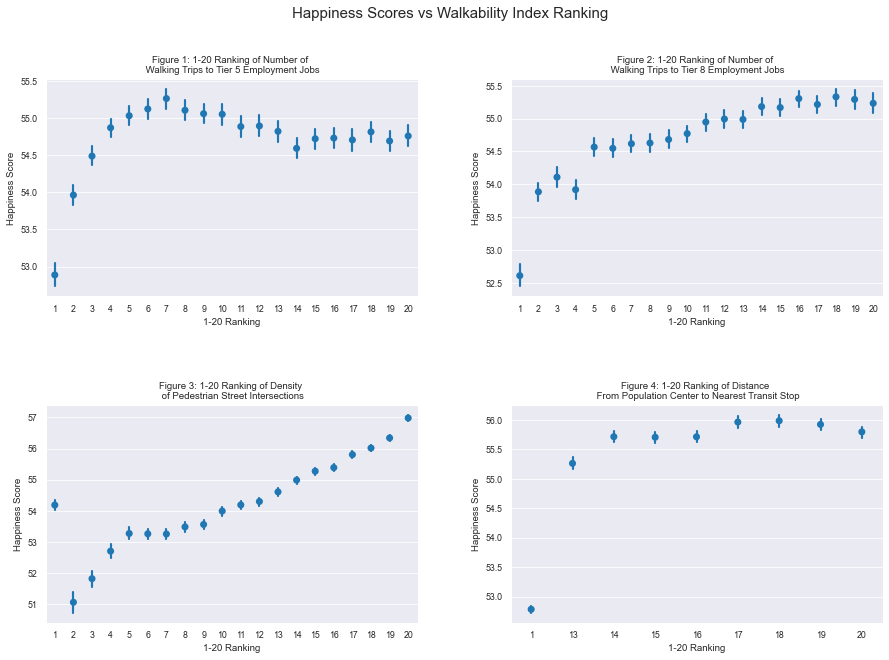

In [205]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(15, 10)
fig.subplots_adjust(hspace=0.5, wspace = 0.25)

targets = ['D2A_Ranked', 'D2B_Ranked', 'D3B_Ranked', 'D4A_Ranked']

for i, ax in enumerate(axes.flatten()):
    g = sns.pointplot(x = targets[i], y = 'Total Score', data = matches, join = False, ax = ax)
    g.set_xticklabels(g.get_xticklabels())
    g.set_xlabel(xlabel = '1-20 Ranking')
    g.set_ylabel('Happiness Score')
    
# set titles
axes[0][0].set_title('Figure 1: 1-20 Ranking of Number of \n Walking Trips to Tier 5 Employment Jobs')
axes[0][1].set_title('Figure 2: 1-20 Ranking of Number of \n Walking Trips to Tier 8 Employment Jobs')
axes[1][0].set_title('Figure 3: 1-20 Ranking of Density \n of Pedestrian Street Intersections')
axes[1][1].set_title('Figure 4: 1-20 Ranking of Distance \n From Population Center to Nearest Transit Stop')

fig.suptitle("Happiness Scores vs Walkability Index Ranking", fontsize = 15)

<h3>Walkability Scores for Happiest Cities</h3>

In [ ]:
# weak inverse relatioship between not owning a car and happiness
# wealth as a confounding variable?
sns.scatterplot(x = 'Pct_AO0', y = 'Total Score', data = df )

In [ ]:
sns.scatterplot(x = 'PCT_protected', y = 'Total Score', data = df)

In [ ]:
sns.scatterplot(x = 'PCT_protected', y = 'Community & Environment', data = df)

<h4>Association Between Density and Housing</h4>

In [ ]:
# generally positive
# D1A = Residential density
sns.scatterplot(x = 'D1A', y = 'Total Score', data = df)

In [ ]:
sns.barplot(x = df['D1A'], y = df.index, data = df)